In [1]:
import numpy as np
import scipy.fftpack, scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def val2cheb(fk):
    c = scipy.fftpack.dct(fk, 1) / (len(fk)-1)
    c[0] /= 2
    c[-1] /= 2
    return c

In [3]:
def chebpts(N): return np.cos(np.arange(N+1)*np.pi/N)

In [4]:
def clenshaw(c,x):
    N=len(c)
    q0=c[N-1]
    if N>1:
        q1=q0
        q0=c[N-2]+2*x*c[N-1]
        for i in range(N-3,-1,-1):
            q2=q1
            q1=q0
            q0=c[i]+2*x*q1-q2
        q0=q0-x*q1
    return q0

# Question 2

In [5]:
test_functions = [
    lambda x: np.sin(5*x)*np.exp(-4*np.sin(x)),
    lambda x: np.log(x + 1.01)
]
N_functions = len(test_functions)
xlin = np.linspace(-1, 1, 1000)

Let's plot both test functions to see how they look like (this is not necessary for students' solutions).

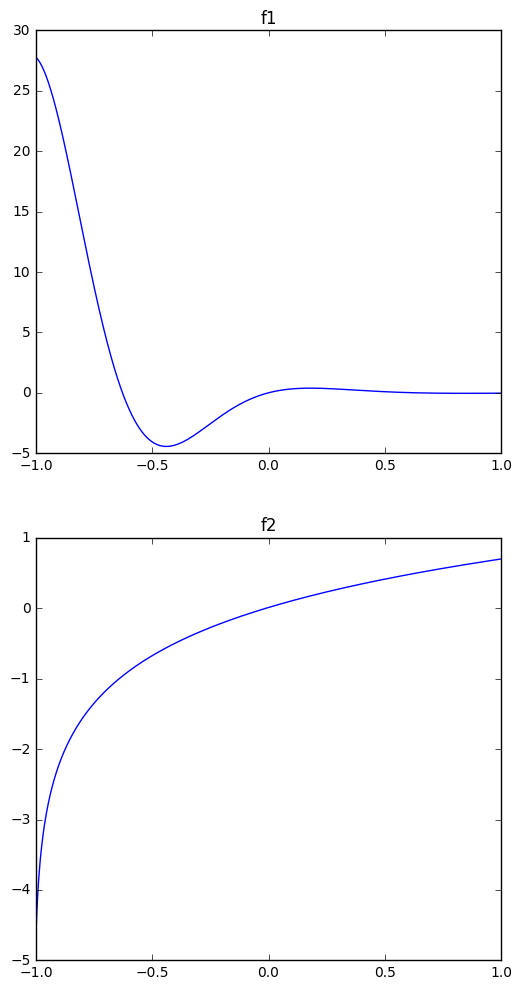

In [6]:
plt.figure(figsize=(6, 6*N_functions))
for i, f in enumerate(test_functions):
    plt.subplot(N_functions, 1, i+1)
    plt.title('f' + str(i+1))
    plt.plot(xlin, f(xlin))

Now we write a function that takes a function f as input and makes both required plots.

<font color='red'>Many of you computed approximation errors (f_err_list) only on Chebyshev points, instead of xlin like in the code below. This does not make sense, because on Chebyshev points the approximation is exact, so approximation error is just 0, which shows as a very small value on a computer due to rounding errors. In that case the second plot does not make sense (the error increases with the number of points).</font>

In [7]:
def plot_coeffs(f):
    NMAX = 300
    N_list = list(range(2, NMAX+1))
    c_err_list = []
    f_err_list = []
    for N in N_list:
        c_cheb = val2cheb(f(chebpts(N)))
        c_err_list.append(np.sum(np.abs(c_cheb[-3:])))
        f_err_list.append(np.max(np.abs(f(xlin)-clenshaw(c_cheb, xlin))))
    plt.figure(figsize=(6, 12))
    plt.subplot(2, 1, 1)
    plt.title("Coefficient errors")
    plt.semilogy(N_list, c_err_list)
    plt.subplot(2, 1, 2)
    plt.title("Approximation errors")
    plt.semilogy(N_list, f_err_list)

Plot coeffs for the first function: f(x) = sin(5x)*exp(-4sin(x))

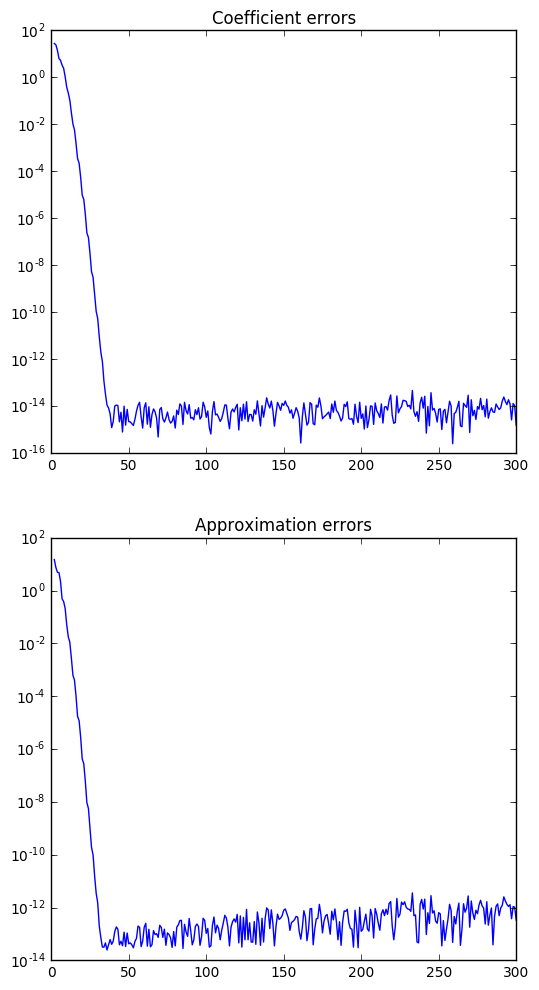

In [8]:
plot_coeffs(test_functions[0])

Same for second function: f(x) = log(x + 1.01). 

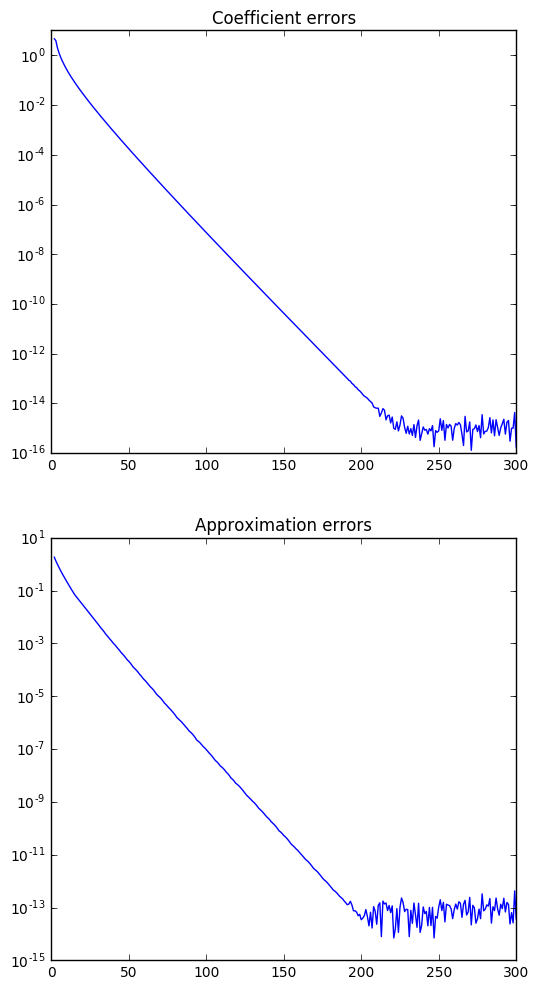

In [9]:
plot_coeffs(test_functions[1])

Conclusions:<br>
1) Coefficient and approximation errors seem to be proportional.<br>
2) Convergence for logarithm is much slower.<br>
3) In both cases error decreases exponentially fast.<br>
4) At some point we reach machine precision limit.

# Question 3

In [10]:
"Warning: no check on convergence."
def adaptive_cheb(f):
    N = 7
    err, err_max = 1, 1e-12
    while err > err_max:
        N += 1
        x_cheb = chebpts(N)
        f_cheb = f(x_cheb)
        c_cheb = val2cheb(f_cheb)
        err = np.sum(np.abs(c_cheb[-3:]))
    return c_cheb, f_cheb

## Test code

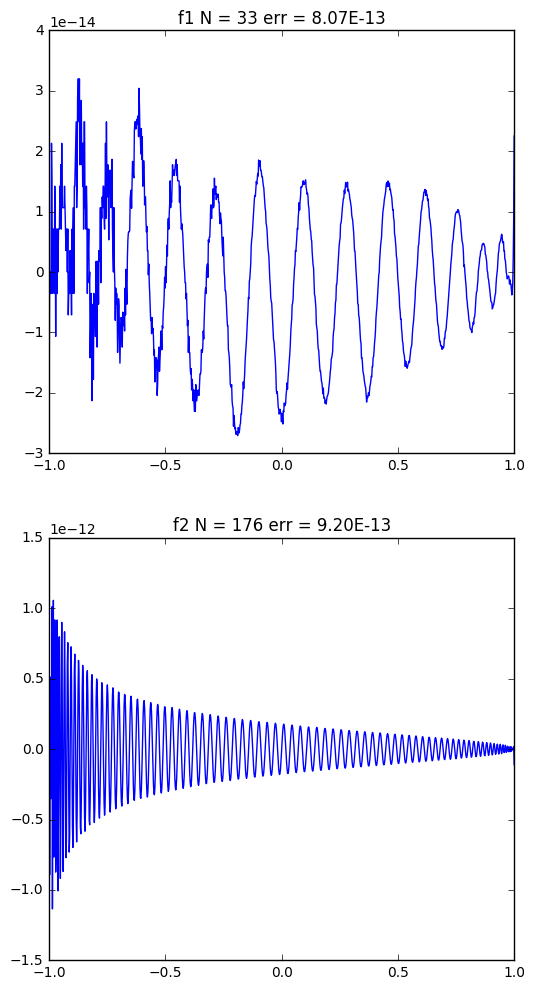

In [11]:
plt.figure(figsize=(6, 6*N_functions))
for i, f in enumerate(test_functions):
    plt.subplot(N_functions, 1, i+1)
    c_cheb, f_cheb = adaptive_cheb(f)
    plt.title('f%s N = %s err = %.2E' % 
              (i+1, len(c_cheb)-1, np.sum(np.abs(c_cheb[-3:]))))
    plt.plot(xlin, f(xlin)-clenshaw(c_cheb, xlin))

# Question 4

In [12]:
def adaptive_integral(f):
    c_cheb = adaptive_cheb(f)[0][::2]
    A = 2*np.arange(0, len(c_cheb))
    return 2*sum(c_cheb / (1-A*A))

## Test code

In [13]:
for i, f in enumerate(test_functions):
    int_ad = adaptive_integral(f)  # Compute integral with our function
    int_scipy = scipy.integrate.quad(f, -1, 1)[0]  # Compute integral with built-in NumPy
    print('f%d:\n'
          'integral via approximation:\t%.8E\n'
          'integral from library:\t\t%.8E\n' 
          'relative error:\t\t\t%.8E'%
          (i+1, int_ad, int_scipy, np.abs((int_ad-int_scipy)/int_scipy)))

f1:
integral via approximation:	3.97114235E+00
integral from library:		3.97114235E+00
relative error:			3.35487251E-16
f2:
integral via approximation:	-5.50697507E-01
integral from library:		-5.50697507E-01
relative error:			3.22564896E-15
